<a href="https://colab.research.google.com/github/leochame/Computer-Study-Note/blob/main/llm/llms-from-srcatch/ch03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# 此内容为代码格式
```

# 前言
在本章我们研究最重要的注意力机制。
我们将要实现的不同注意力机制。我们将从一个简化版本的自注意力机制开始，然后逐步加入可训练的权重。因果注意力机制在自注意力的基础上增加了额外掩码，使得大语言模型可以一次生成一个单词。最后，多头注意力将注意力机制划分成多个头，从而使模型能够并行捕获输入数据的各种特征

注意力机制的核心思想是对文本进行任何操作，在生成文本的地方，我们随时可以查看整个输入。因此

# 3.3 简单注意力机制

自注意力机制（Self-Attention）是什么？
自”指的是自注意力机制是作用在单个输入序列上的，而不是两个不同的序列。也就是说，在计算一个序列的表示时，它会关注序列内部不同位置之间的关系，而不是序列之间的关系。例如，在处理句子时，它会评估句子中不同单词之间的依赖关系，而不是输入和输出之间的依赖。例子：

* 在句子“猫追逐着小狗”的处理中，自注意力机制会计算“猫”和“追逐”之间、“追逐”和“小狗”之间的关系，以及它们如何共同影响句子的理解。

传统的注意力机制通常用于序列到序列（seq2seq）模型中，比如在机器翻译中，输入序列和输出序列之间存在关联。注意力机制会在这两个序列间寻找关联，而不是单纯在输入序列内部进行计算。
* 比如，机器翻译时，输入句子（如英语）会与输出句子（如中文）之间的某些位置进行对齐，注意力机制会根据这一对齐关系分配不同的权重

自注意力机制的关键在于**计算注意力权重**，这些权重决定了序列中不同部分的重要性。这些权重并不是固定的，而是可以通过训练数据来学习的，这就是“带可训练权重”的含义。通过优化这些权重，模型能够更好地捕捉序列内部的依赖关系。




我们首先实现一个不包含任何可训练权重的简化的自注意力机制变体



考虑输入文本“Your journey starts with one step.”在这种情况下，文本序列中的每个元素都对应一个 d
维的嵌入向量，该向量代表了一个特定的词元，比如“Your”​。

在自注意力机制中，我们的目标是为输入序列中的每个元素  X^i 计算上下文向量 Z^i。上下文向量(context vector)可以被理解为一种包含了序列中所有元素信息的嵌入向量。

我们选择较小的嵌入维度进行说明。

In [4]:
import torch
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

如何计算查询词元与每个输入词元之间的中间注意力分数呢？

我们通过计算查询词元 X^2 与其他所有输入词元的点积来确定这些分数

我们之后会采用torch..dot来计算点积。我们先写一个点积含义的例子，提供给你参考。

In [5]:
query = inputs[1]
attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
  attn_scores_2[i] = torch.dot(x_i,query)
print(attn_scores_2)


res = 0.
for idx, element in enumerate(inputs[0]):
    res += inputs[0][idx] * query[idx]
print(res)
print(torch.dot(inputs[0], query))

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])
tensor(0.9544)
tensor(0.9544)


点积不仅被视为一种将两个向量转化为标量值的数学工具，而且也是度量相似度的一种方式，因为它可以量化两个向量之间的对齐程度：点积越大，向量之间的对齐程度或相似度就越高。在自注意机制中，点积决定了序列中每个元素对其他元素的关注程度：点积越大，两个元素之间的相似度和注意力分数就越高。   

在下一步中，我们将对先前计算的每个注意力分数进行归一化处理。归一化的主要目的是获得总和为1的注意力权重。

In [6]:
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()
print("Attention weights:", attn_weights_2_tmp)
print("Sum:", attn_weights_2_tmp.sum())

Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)


在实际应用中，使用softmax函数进行归一化更为常见，而且是一种更可取的做法。这种方法更好地处理了极值，并在训练期间提供了更有利的梯度特性。


另外，softmax函数可以保证注意力权重总是正值，这使得输出可以被解释为概率或相对重要性，其中权重越高表示重要程度越高。

In [7]:
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)
print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


通过将每个输入词元的嵌入向量与它对应的注意力权重相乘，再将这些结果加起来，得到该词元的上下文向量。  
> 这个过程本质上是通过加权求和来聚合序列中各个元素的信息，从而为每个词元生成一个综合了其他元素信息的表示。

In [8]:
query = inputs[1]
context_vec_2 = torch.zeros(query.shape)
for i,x_i in enumerate(inputs):
  context_vec_2 += attn_weights_2[i]*x_i
print(context_vec_2)

tensor([0.4419, 0.6515, 0.5683])


## 计算所有输入词元的注意力权重

到目前为止，我们已经计算了输入2的注意力权重和上下文向量接下来，我们将扩展这个计算过程，以计算所有输入的注意力权重和上下文向量。

In [9]:
attn_scores = torch.empty(6, 6)
for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i, j] = torch.dot(x_i, x_j)
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


在计算前面的注意力分数张量时，我们使用了Python中的for循环。然而，for循环通常较慢，因此可以使用矩阵乘法来得到相同的结果：

In [10]:
attn_scores = inputs @ inputs.T
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [11]:
# 对每一行进行归一化，以确保每一行中的值总和为1
attn_weights = torch.softmax(attn_scores, dim=-1)
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


In [12]:
# 验证一下每一行的总和是否确实为1：
row_2_sum = sum([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
print("Row 2 sum:", row_2_sum)
print("All row sums:", attn_weights.sum(dim=-1))

Row 2 sum: 1.0
All row sums: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


最后一步，我们用这些注意力权重通过矩阵乘法计算出所有**上下文向量**：

In [13]:
all_context_vecs = attn_weights @ inputs
print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


现在，简单自注意力机制的代码已经完成了。
接下来，我们将添加可训练的权重，使大语言模型能够从数据中学习，并提升其在特定任务上的性能。

# 3.4 实现带可训练权重的自注意力机制

之前，我们实现了一个简化的注意力机制，以理解注意力机制背后的基本原理。现在，我们将为此注意力机制添加可训练的权重。

每个输入元素（如“Your”，“journey”，“starts”，“with”，“one”，“step”）被转换为三种向量：查询向量
𝑞，键向量
𝑘 和 值向量
𝑣。

查询、键和值向量是通过与权重矩阵（如
𝑊
𝑞，
𝑊
𝑘，
𝑊
𝑣​
 ）的矩阵运算得到的。这个过程将每个输入元素转换为这些向量，从而为后续的注意力计算做好准备。

 * 查询向量是自注意力机制中用于“提问”的部分。它用于表示当前要查询的元素（例如当前词元）在上下文中的位置。
 * 键向量是与每个输入元素关联的向量，表示该元素的特征，并且它与查询向量用来计算相似度。
 * 值向量是与键向量一起与查询向量进行配对的向量。它包含了**实际的信息**，即对计算上下文向量有贡献的内容。在计算过程中，值向量会根据查询向量和键向量的相似度（即注意力权重）进行加权求和，最终形成上下文向量。

对于每个输入元素，查询向量是通过该元素与权重矩阵
𝑊
𝑞 计算得到的。类似地，键向量和值向量分别通过与
𝑊
𝑘
​
  和
𝑊
𝑣
​
  进行计算得到。

上下文向量
𝑐
(
2
)
  是基于第二个输入元素
𝑥
(
2
)的查询向量与所有其他元素的键和值向量计算得出的。通过对其他元素的注意力权重加权得到该元素的上下文表示。

In [14]:
x_2 = inputs[1]
d_in = inputs.shape[1] # 输入维度
d_out = 2 # 输出维度

In [16]:
# 设置requires_grad=False以减少输出中的其他项，但如果要在模型训练中使用这些权重矩阵，就需要设置requires_grad=True，以便在训练中更新这些矩阵。
torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key   = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

In [18]:
# 计算查询向量、键向量和值向量
query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value
print(query_2)

tensor([0.4306, 1.4551])


权重参数：这是神经网络中的可训练参数，在训练过程中通过优化来调整，决定了网络中不同连接的强度。

注意力权重：这是一种动态的值，表示网络在给定上下文时对输入不同部分的关注程度。注意力权重依赖于当前输入和上下文，因此会随着每次计算而变化。

虽然目前我们的目标只是计算一个上下文向量
𝑧
(
2
)
 ，但仍然需要所有输入元素的查询量、键值量和值向量，因为它们参与了计算查询
𝑞
(
2
)
的注意力权重

In [20]:
# 通过矩阵乘法得到所有的键向量和值向量
keys = inputs @ W_key
values = inputs @ W_value
print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])


为了使得查询向量和键向量能够更加适应任务，我们先使用权重矩阵对它们进行转换。换句话说，查询向量和键向量不会直接用于点积计算，而是先通过权重矩阵进行线性变换（矩阵乘法），然后再进行点积计算。

值得注意的是，为了使得查询向量和键向量能够更加适应任务，我们先使用权重矩阵对它们进行转换。换句话说，查询向量和键向量不会直接用于点积计算，而是先通过权重矩阵进行线性变换（矩阵乘法），然后再进行点积计算。

In [22]:
# 首先计算出注意力分数 w_22
keys_2 = keys[1]
attn_score_22 = query_2.dot(keys_2)
print(attn_score_22)

tensor(1.8524)


In [24]:
# 同样，可以通过矩阵乘法将这个计算推广到所有的注意力分数
attn_scores_2 = query_2 @ keys.T
print(attn_scores_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


现在，我们想要将注意力分数转换为注意力权重。我们通过缩放注意力分数并应用softmax函数来计算注意力权重。不过，此时是通过将注意力分数除以键向量的嵌入维度的平方根来进行缩放。

In [25]:
d_k = keys.shape[-1]
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)
print(attn_weights_2)

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])


在计算完注意力分数后，下一步是使用softmax函数对这些分数进行归一化，以获得注意力权重

通过对值向量进行加权求和来计算上下文向量。在这里，注意力权重作为加权因子，用于权衡每个值向量的重要性。

In [26]:
context_vec_2 = attn_weights_2 @ values
print(context_vec_2)

tensor([0.3061, 0.8210])


到目前为止，我们只计算了一个上下文向量 Z_2

##  实现一个简化的自注意Python类

到目前为止，我们已经完成了多个步骤来计算自注意力的输出。这些步骤主要是为了演示清晰，以便逐步了解每个环节。在实际操作中，为了实现第4章中的大语言模型，最好将这些代码组织成一个Python类


In [28]:
import torch.nn as nn
# 这里定义了一个名为SelfAttention_v1的类，继承了nn.Module。
# nn.Module是PyTorch中所有神经网络模块的基类，
# 提供了模型的常见功能，比如前向传播和参数管理。
class SelfAttention_v1(nn.Module):
# __init__方法是类的构造函数，用于初始化类的成员变量。
# d_in表示输入的维度，d_out表示输出的维度。
    def __init__(self, d_in, d_out):
        super().__init__()
#self.W_query、self.W_key和self.W_value是查询矩阵（Query）、键矩阵（Key和值矩阵（Value），
# 它们的形状为(d_in, d_out)。
# nn.Parameter表示这些矩阵是需要在训练过程中学习的可训练参数。
# torch.rand(d_in, d_out)生成一个大小为d_in x d_out的随机矩阵，作为初始值。
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key   = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value
        attn_scores = queries @ keys.T # omega
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        context_vec = attn_weights @ values
        return context_vec

In [30]:
class SelfAttention_v2(nn.Module):
    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        context_vec = attn_weights @ values
        return context_vec

In [31]:
torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


# 3.5 利用因果注意力隐藏未来词汇

因果注意力机制限制模型在处理任何给定词元时，只能基于序列中的先前和当前输入来计算注意力分数，而标准的自注意力机制可以一次性访问整个输入序列。

在因果注意力机制中，我们掩码了对角线以上的注意力权重，以确保在计算上下文向量时，大语言模型无法访问未来的词元。例如，对于第2行的单词“journey”​，仅保留当前词(“journey”)和之前词(“Your”)的注意力权重

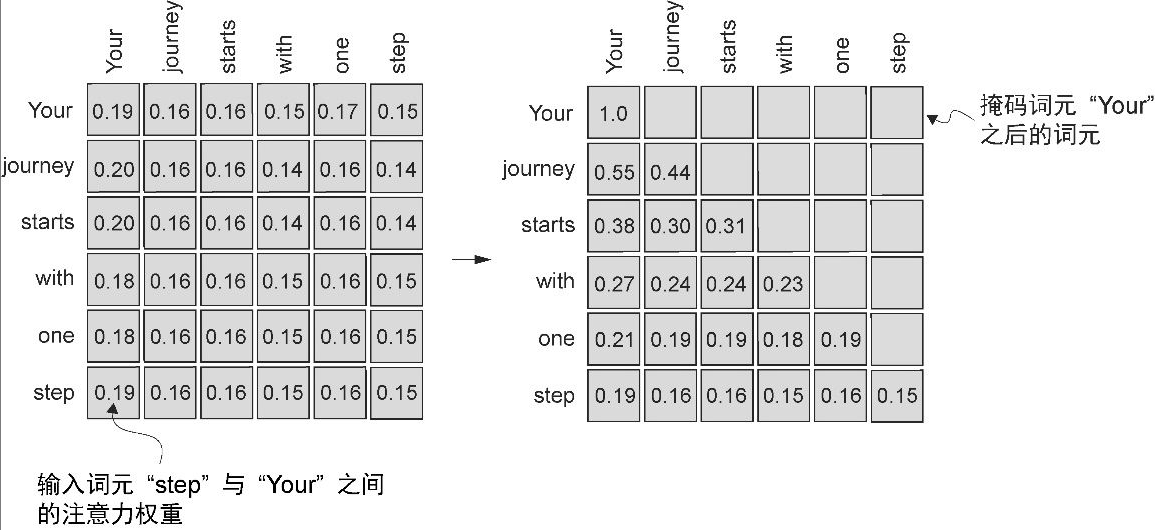

In [ ]:
queryies = sa_v2.Wquery(inputes)